# <font color='red'>Problem 1:

Variational Autoencoder

## <font color='orange'>First we import the libraries that we use</font>

In [11]:
from IPython import display

import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import scipy.stats

## <font color='orange'>Loading the MNIST dataset:</font>

MNIST dataset consists of digits images from $0$ to $9$.


In [12]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [13]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)
train_size = 60000
batch_size = 128
test_size = 10000

## <font color='orange'>Shuffling data:</font>

In [14]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

## <font color='orange'>Building the encoder and decoder networks:</font>

In VAE, we implement two ConvNets for the encoder and decoder networks.

Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

### <font color='green'>Encoder network:</font>
This defines the approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation $z$.

We simply model the distribution as a diagonal Gaussian, and the network outputs the mean and log-variance parameters of a factorized Gaussian.

### <font color='green'>Decoder network: </font>
This defines the conditional distribution of the observation $p(x|z)$, which takes a latent sample $z$ as input and outputs the parameters for a conditional distribution of the observation.
We model the latent distribution prior $p(z)$ as a unit Gaussian.

### <font color='green'>The reparameterization trick:</font>
To generate a sample $z$ for the decoder during training, we sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation $x$.
We approximate $z$ using the decoder parameters and another parameter $\epsilon$ as follows:

$$z = \mu + \sigma \odot \epsilon$$

where $\mu$ and $\sigma$ are the mean and standard deviation of a Gaussian distribution respectively. They are derived from the decoder output. The $\epsilon$ is a random noise used to maintain stochasticity of $z$. We generate $\epsilon$ from a standard normal distribution.

## <font color='orange'>Network architecture:</font>

## <font color='green'>Encoder:</font>
For the encoder network, we use two convolutional layers followed by a fully-connected layer.

## <font color='green'>Decoder:</font>
In the decoder network, we mirror this architecture by using a fully-connected layer followed by three convolution transpose layers.


In [15]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

## <font color='orange'>Defining the loss function and the optimizer:</font>

We train VAE by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In order to maximize $\text{ELBO}$, we optimize the single sample Monte Carlo estimate of this expectation:

$$\log \frac{p(x, z)}{q(z|x)}=\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

**<font color='red'>Note:</font>** we could also analytically compute the KL term, but here we incorporate all three terms in the Monte Carlo estimator for simplicity.

In [16]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """
  Executes one training step and returns the loss.
  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## <font color='orange'>Training algorithm:</font>

* We start by iterating over the dataset
* During each iteration, we pass the image to the encoder to obtain a set of mean and log-variance parameters of the approximate posterior $q(z|x)$
* We then apply the *reparameterization trick* to sample from $q(z|x)$
* Finally, we pass the reparameterized samples to the decoder to obtain the logits of the generative distribution $p(x|z)$
* After each $10$ epochs we plot $10\times 10$ images to visualize the progress of cvae


In [17]:
epochs = 25
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
n = 10
num_examples_to_generate = n**2

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [18]:
def generate_and_save_images(model, epoch, test_sample, n):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(n, n))

  for i in range(predictions.shape[0]):
    plt.subplot(n, n, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.show()

In [19]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

## <font color='orange'>Training:</font>

During training we will see that the result images are getting better.

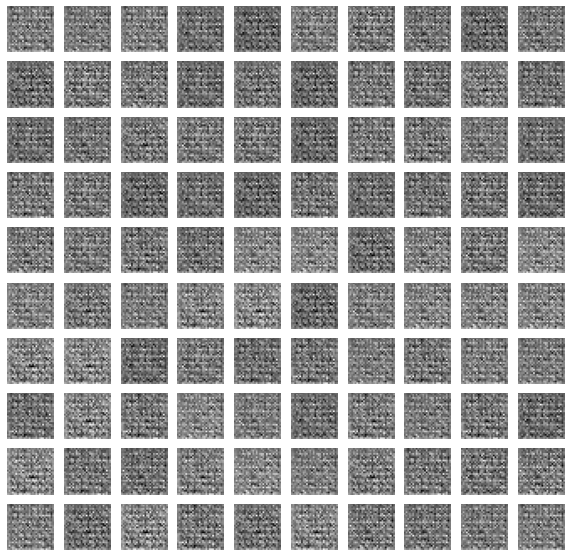

Epoch: 1, Test set ELBO: -211.7706756591797, time elapse for current epoch: 7.127173185348511


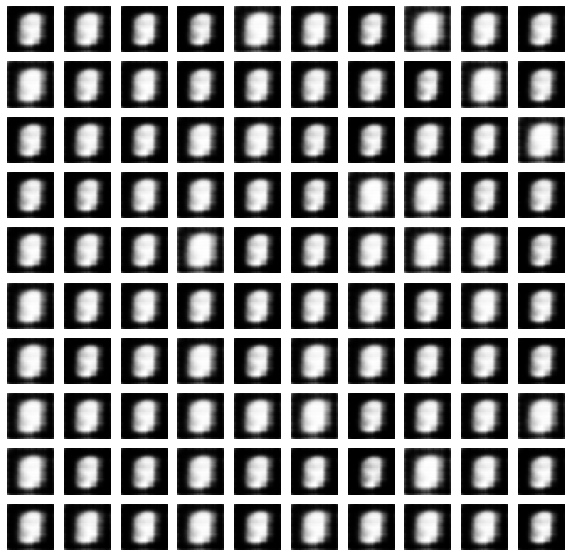

Epoch: 2, Test set ELBO: -190.3753204345703, time elapse for current epoch: 6.224100828170776
Epoch: 3, Test set ELBO: -179.83624267578125, time elapse for current epoch: 6.092782735824585
Epoch: 4, Test set ELBO: -174.3510284423828, time elapse for current epoch: 6.311107158660889
Epoch: 5, Test set ELBO: -171.94644165039062, time elapse for current epoch: 6.1718127727508545
Epoch: 6, Test set ELBO: -169.95675659179688, time elapse for current epoch: 6.060480356216431


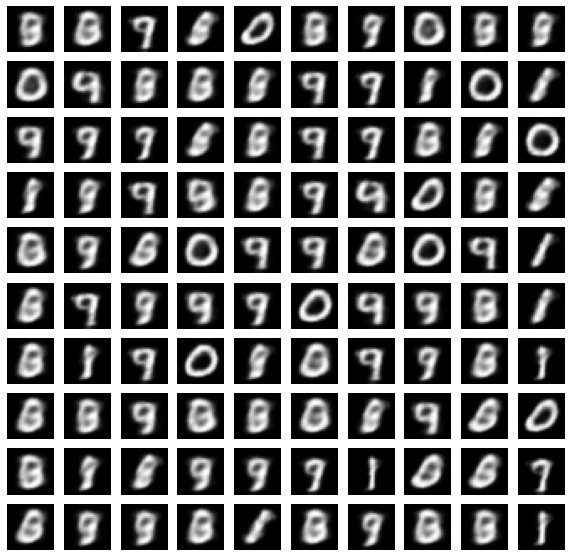

Epoch: 7, Test set ELBO: -168.2510223388672, time elapse for current epoch: 6.254309177398682
Epoch: 8, Test set ELBO: -166.1528778076172, time elapse for current epoch: 6.249594688415527
Epoch: 9, Test set ELBO: -164.8643341064453, time elapse for current epoch: 6.141801834106445
Epoch: 10, Test set ELBO: -163.22265625, time elapse for current epoch: 6.167964935302734
Epoch: 11, Test set ELBO: -162.32513427734375, time elapse for current epoch: 6.238837718963623


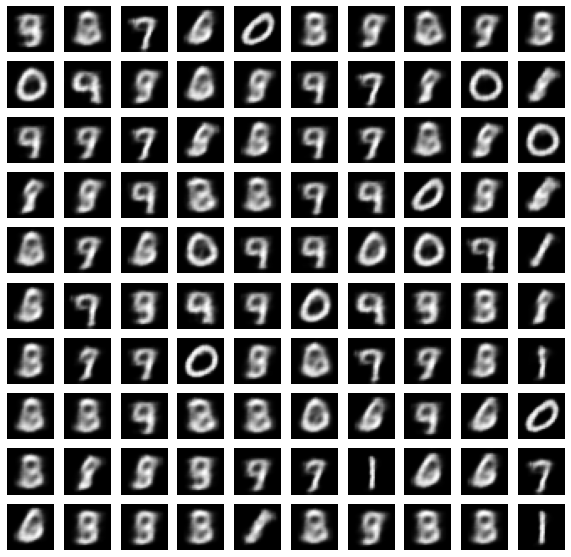

Epoch: 12, Test set ELBO: -161.1726531982422, time elapse for current epoch: 6.180715799331665
Epoch: 13, Test set ELBO: -160.26954650878906, time elapse for current epoch: 6.295807361602783
Epoch: 14, Test set ELBO: -159.93592834472656, time elapse for current epoch: 6.147259712219238
Epoch: 15, Test set ELBO: -159.24424743652344, time elapse for current epoch: 6.2092015743255615
Epoch: 16, Test set ELBO: -158.6322784423828, time elapse for current epoch: 6.297785758972168


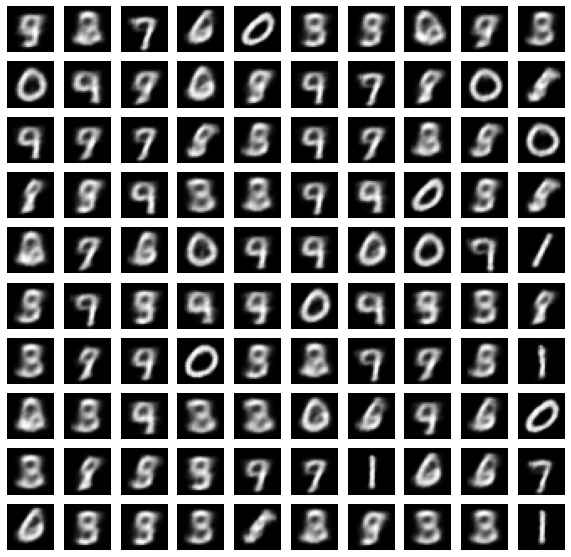

Epoch: 17, Test set ELBO: -157.9197540283203, time elapse for current epoch: 6.214385271072388
Epoch: 18, Test set ELBO: -157.5299530029297, time elapse for current epoch: 6.165069818496704
Epoch: 19, Test set ELBO: -157.37841796875, time elapse for current epoch: 6.130036115646362
Epoch: 20, Test set ELBO: -157.0671844482422, time elapse for current epoch: 6.096823453903198
Epoch: 21, Test set ELBO: -156.61827087402344, time elapse for current epoch: 6.084318399429321


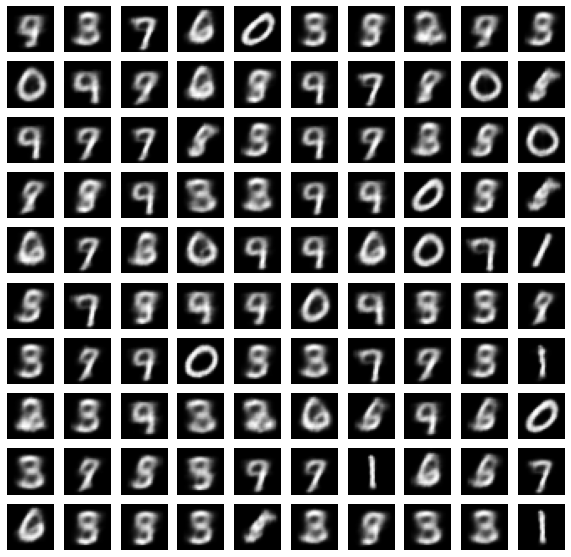

Epoch: 22, Test set ELBO: -156.64892578125, time elapse for current epoch: 6.126353025436401
Epoch: 23, Test set ELBO: -155.99623107910156, time elapse for current epoch: 6.06134819984436
Epoch: 24, Test set ELBO: -155.779541015625, time elapse for current epoch: 6.247313976287842
Epoch: 25, Test set ELBO: -155.74551391601562, time elapse for current epoch: 6.170748233795166


In [20]:
generate_and_save_images(model, 0, test_sample, n)
train_loss_values = np.zeros(epochs)
test_loss_values = np.zeros(epochs)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  loss = tf.keras.metrics.Mean()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
    loss(compute_loss(model, train_x))
  train_loss_values[epoch-1] = loss.result().numpy()
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  test_loss_values[epoch-1] = loss.result().numpy()
  #display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  if epoch % 5 == 1:
    generate_and_save_images(model, epoch, test_sample, n)

Text(0.5, 1.0, "Model's Loss")

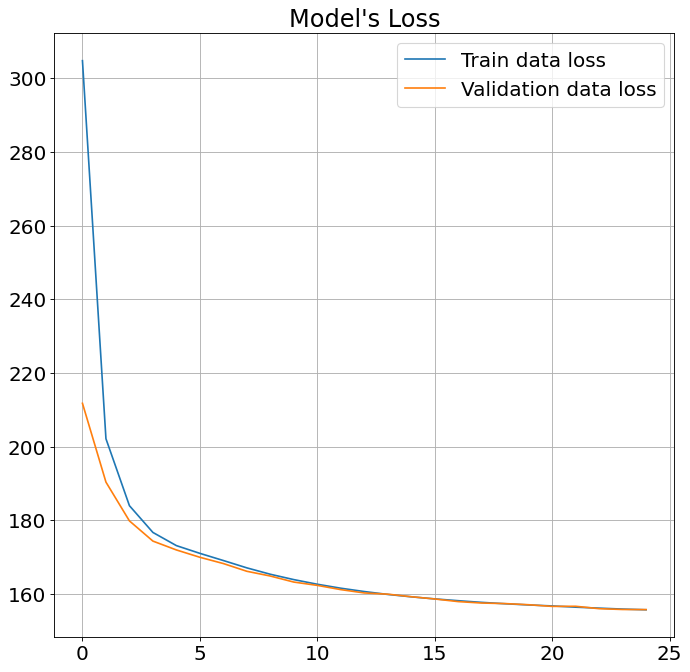

In [21]:
plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.plot(train_loss_values, label="Train data loss")
plt.plot(test_loss_values, label="Validation data loss")
plt.grid('on')
plt.legend()
plt.title('Model\'s Loss')

### <font color='orange'>Display a 2D manifold of digits from the latent space:</font>

Running the code below will show a continuous distribution of the different digit classes, with each digit morphing into another across the 2D latent space.

In [22]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  #norm = tfp.distributions.Normal(0, 1)
  
  grid_x = scipy.stats.norm.ppf(np.linspace(0.05, 0.95, n))
  grid_y = scipy.stats.norm.ppf(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

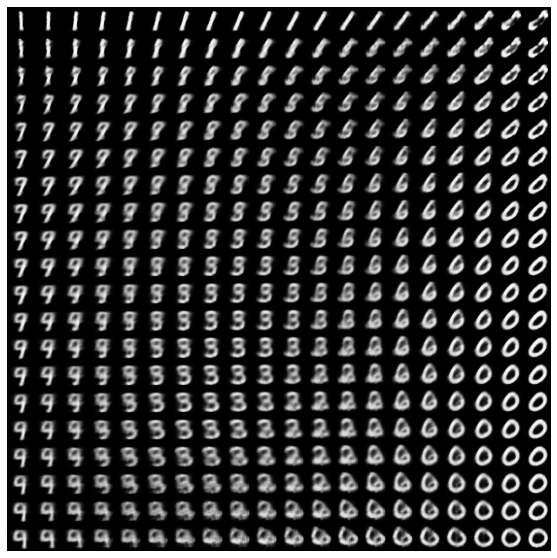

In [23]:
plot_latent_images(model, 20, 28)

### <font color='orange'>Displayin 2D plot oof digit classes in latent space:</font>

In [31]:
def plot_label_clusters(model, data, labels, title):
  # display a 2D plot of the digit classes in the latent space
  z_mean, logvar = model.encode(data)
  plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='w')
  font = {'weight' : 'normal',
          'size'   : 18}
  plt.rc('font', **font)
  plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
  plt.colorbar()
  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.title(title)
  plt.show()

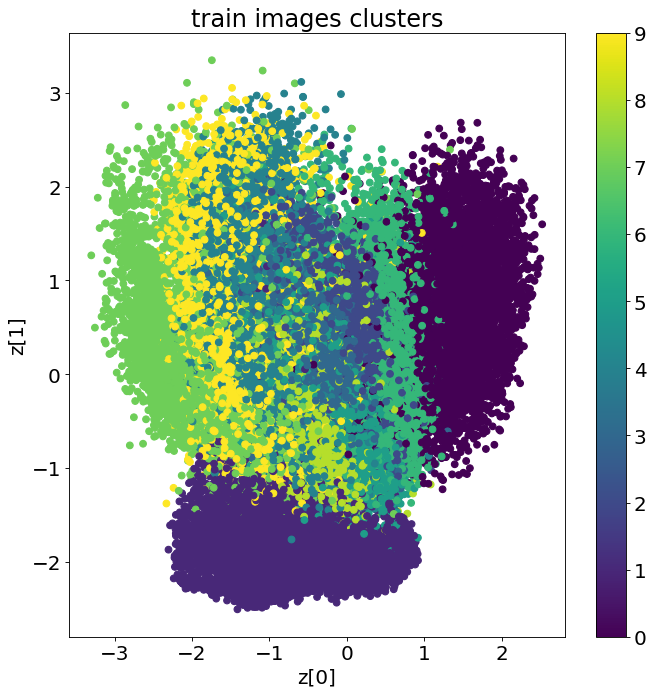

In [32]:
title = "train images clusters"
plot_label_clusters(model, train_images, train_labels, title)

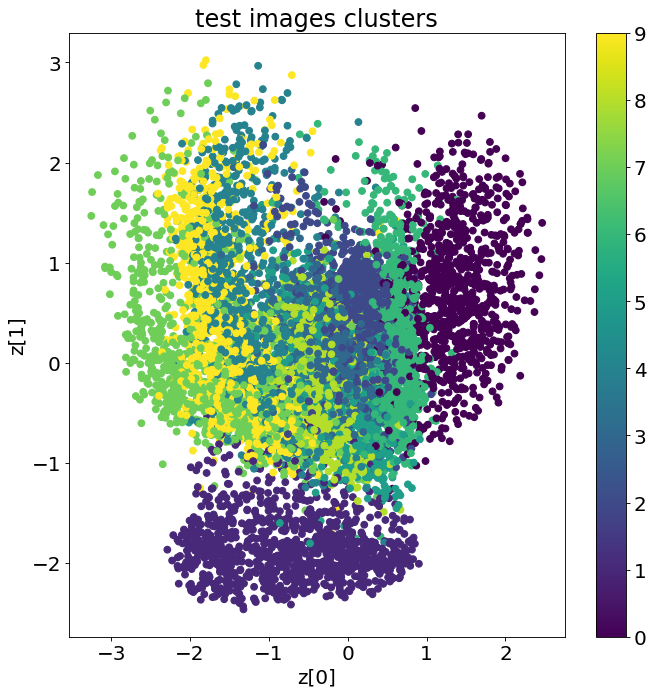

In [33]:
title = "test images clusters"
plot_label_clusters(model, test_images, test_labels, title)